In [1]:
import time

import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

# random seed
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Problem Setting

In [2]:
# init
steepness = 50    # steepness factor
num_blocks = 1    # number of expression blocks
num_data = 9100   # number of data
test_size = 100   # number of test size
val_size = 1000   # number of validation size
train_size = num_data - test_size - val_size

In [3]:
# parameters as input data
p_low, p_high = 1.0, 8.0
a_low, a_high = 0.5, 4.5
p_train = np.random.uniform(p_low, p_high, (train_size, 1)).astype(np.float32)
p_test  = np.random.uniform(p_low, p_high, (test_size, 1)).astype(np.float32)
p_dev   = np.random.uniform(p_low, p_high, (val_size, 1)).astype(np.float32)
a_train = np.random.uniform(a_low, a_high, (train_size, num_blocks)).astype(np.float32)
a_test  = np.random.uniform(a_low, a_high, (test_size, num_blocks)).astype(np.float32)
a_dev   = np.random.uniform(a_low, a_high, (val_size, num_blocks)).astype(np.float32)

In [4]:
# nm datasets
from neuromancer.dataset import DictDataset
data_train = DictDataset({"p":p_train, "a":a_train}, name="train")
data_test = DictDataset({"p":p_test, "a":a_test}, name="test")
data_dev = DictDataset({"p":p_dev, "a":a_dev}, name="dev")
# torch dataloaders
from torch.utils.data import DataLoader
batch_size = 64
loader_train = DataLoader(data_train, batch_size, num_workers=0, collate_fn=data_train.collate_fn, shuffle=True)
loader_test = DataLoader(data_test, batch_size, num_workers=0, collate_fn=data_test.collate_fn, shuffle=False)
loader_dev = DataLoader(data_dev, batch_size, num_workers=0, collate_fn=data_dev.collate_fn, shuffle=True)

In [5]:
# example data point
p, a = p_test[1], a_test[1]
datapoints = {"p": torch.tensor(np.array([p]), dtype=torch.float32).to("cuda"), 
              "a": torch.tensor(np.array([a]), dtype=torch.float32).to("cuda"),
              "name": "test"}

## Optimization Model

In [6]:
from src.problem import msRosenbrock
model = msRosenbrock(steepness, num_blocks, timelimit=60)

In [7]:
rng = np.random.RandomState(17)
b = rng.normal(scale=1, size=(num_blocks))
q = rng.normal(scale=1, size=(num_blocks))
print(b, q)

[0.27626589] [-1.85462808]


In [8]:
params = {"p":p_test[1], "a":a_test[1]}
model.set_param_val(params)
solvals, objval = model.solve()
print(solvals)
print(objval)

{'x': {0: -1.7226204622933592, 1: 3.0}}
31.649441749800694


## Trainer

In [9]:
import copy

class trainer:
    def __init__(self, components, loss_fn, optimizer, epochs=100,
                 patience=5, warmup=0, clip=100, loss_key="loss", device="cpu"):
        """
        Initialize the Trainer class.
        """
        self.components = components
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.patience = patience
        self.warmup = warmup
        self.clip = clip
        self.loss_key = loss_key
        self.device = device
        self.early_stop_counter = 0
        self.best_loss = float("inf")
        self.best_model_state = None

    def train(self, loader_train, loader_dev, datapoints):
        """
        Perform training with early stopping.
        """
        sols_rel, sols_rnd = [], []
        # initial validation loss calculation
        self.components.eval()
        with torch.no_grad():
            val_loss = self.best_loss = self.calculate_loss(loader_dev)
        # training loop
        tick = time.time()
        for epoch in range(self.epochs):
            print(f"Epoch {epoch}, Validation Loss: {val_loss:.2f}")
            for data_dict in loader_train:
                # training phase
                self.components.train()
                # move to device
                for key in data_dict:
                    if torch.is_tensor(data_dict[key]):
                        data_dict[key] = data_dict[key].to(self.device)
                # forwad pass
                for comp in self.components:
                    data_dict.update(comp(data_dict))
                data_dict = self.loss_fn(data_dict)
                # backward pass
                data_dict[self.loss_key].backward()
                torch.nn.utils.clip_grad_norm_(self.components.parameters(), self.clip)
                self.optimizer.step()
                self.optimizer.zero_grad()
                # infer datapoint
                components.eval()
                with torch.no_grad():
                    for comp in components:
                        datapoints.update(comp(datapoints))
                # result
                sols_rel.append(datapoints["x"][0].cpu().numpy())
                sols_rnd.append(datapoints["x_rnd"][0].cpu().numpy())    
            # validation phase
            self.components.eval()
            with torch.no_grad():
                val_loss = self.calculate_loss(loader_dev)
            # early stopping check
            if epoch >= self.warmup:
                early_stop = self.update_early_stopping(val_loss)
                if self.early_stop_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        tock = time.time()
        elapsed = tock - tick
        # end of training
        if self.best_model_state:
            self.components.load_state_dict(self.best_model_state)
            print("Best model loaded.")
        print("Training complete.")
        print(f"The training time is {elapsed:.2f} sec.")
        return np.array(sols_rel), np.array(sols_rnd)

    def calculate_loss(self, loader):
        """
        Calculate loss for a given dataset loader.
        """
        total_loss = 0.0
        for data_dict in loader:
            # move to device
            for key in data_dict:
                if torch.is_tensor(data_dict[key]):
                    data_dict[key] = data_dict[key].to(self.device)
            # forward pass
            for comp in self.components:
                data_dict.update(comp(data_dict))
            total_loss += self.loss_fn(data_dict)[self.loss_key].item()
        return total_loss / len(loader)

    def update_early_stopping(self, val_loss):
        """
        Update the early stopping counter and model state.
        """
        # update with better loss
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(self.components.state_dict())
            self.early_stop_counter = 0  # reset early stopping counter
        else:
            self.early_stop_counter += 1

## Learnable Rounding

In [10]:
# hyperparameters
penalty_weight = 100  # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 4             # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

In [11]:
# set problem
import neuromancer as nm
from src.problem import nmRosenbrock
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_blocks+1, outsize=2*num_blocks, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["p", "a"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=3*num_blocks+1, hidden_dims=[hsize]*hlayers_rnd, output_dim=2*num_blocks)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["p", "a"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmRosenbrock(["p", "a", "x_rnd"], steepness, num_blocks, penalty_weight)

In [12]:
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs, patience, warmup, device="cuda")
# training for the rounding problem
sols_rel, sols_rnd = my_trainer.train(loader_train, loader_dev, datapoints)

Epoch 0, Validation Loss: 633.96
Epoch 1, Validation Loss: 563.72
Epoch 2, Validation Loss: 52.03
Epoch 3, Validation Loss: 39.96
Epoch 4, Validation Loss: 37.59
Epoch 5, Validation Loss: 37.05
Epoch 6, Validation Loss: 37.39
Epoch 7, Validation Loss: 35.72
Epoch 8, Validation Loss: 38.21
Epoch 9, Validation Loss: 36.76
Epoch 10, Validation Loss: 38.36
Epoch 11, Validation Loss: 33.15
Epoch 12, Validation Loss: 32.57
Epoch 13, Validation Loss: 31.43
Epoch 14, Validation Loss: 31.64
Epoch 15, Validation Loss: 30.14
Epoch 16, Validation Loss: 28.77
Epoch 17, Validation Loss: 30.81
Epoch 18, Validation Loss: 28.81
Epoch 19, Validation Loss: 28.83
Epoch 20, Validation Loss: 29.86
Epoch 21, Validation Loss: 30.51
Epoch 22, Validation Loss: 30.46
Epoch 23, Validation Loss: 30.96
Epoch 24, Validation Loss: 30.43
Epoch 25, Validation Loss: 30.27
Epoch 26, Validation Loss: 29.60
Epoch 27, Validation Loss: 26.59
Epoch 28, Validation Loss: 26.70
Epoch 29, Validation Loss: 25.62
Epoch 30, Validati

In [13]:
# infer
components.eval()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
# result
print(datapoints)

{'p': tensor([[5.8110]], device='cuda:0'), 'a': tensor([[3.8984]], device='cuda:0'), 'name': 'test', 'x': tensor([[-1.1376,  2.8636]], device='cuda:0'), 'x_rnd': tensor([[-1.8157,  3.0000]], device='cuda:0')}


In [14]:
# feasibility
for i in model.vars["x"]:
    model.vars["x"][i].value = datapoints["x_rnd"][0, i].item()
print("Constraint Violations: {:.4f}".format(sum(model.cal_violation())))

Constraint Violations: 0.0000


In [15]:
rels = sols_rel[[110, 210, 510, 9010]]
print(rels)
rnds = sols_rnd[[110, 210, 510, 9010]]
print(rnds)

[[ 0.23585738 -0.07161634]
 [-0.55483156  1.310759  ]
 [-1.4072638   3.6759949 ]
 [-1.1234729   2.8567035 ]]
[[ 0.07881497 -1.        ]
 [-0.9385026   2.        ]
 [-1.9336385   4.        ]
 [-1.8058673   3.        ]]


## Visulization

In [16]:
import sympy as sp
from sympy.abc import x, y
from matplotlib import pyplot as plt
import matplotlib.patheffects as patheffects

In [17]:
# objective function
f = (a.item() - x)**2 + 50*(y - x**2)**2
# constraints
constr1 = x ** 2 <= p.item()
constr2 = y >= p.item() / 2
constr3 = b.item() * x <= 0
constr4 = q.item() * y <= 0

In [18]:
# grid data
x_vals = np.linspace(-3, 0.5, 350)
y_vals = np.linspace(-1.3, 5.7, 700)
X, Y = np.meshgrid(x_vals, y_vals)

In [19]:
# obj value
Z = sp.lambdify((x, y), f, "numpy")(X, Y)
Z_log = np.log(Z)

In [20]:
# constraint mask
constraint_mask = (
    (X**2 <= p.item()) &
    (Y >= p.item() / 2) &
    (b.item() * X <= 0) &
    (q.item() * Y <= 0)
)

In [21]:
# sol sequence
sol_seq = []
for i in range(len(rels)):
    sol_seq.append(rels[i])
    sol_seq.append(rnds[i])
sol_seq = np.array(sol_seq)

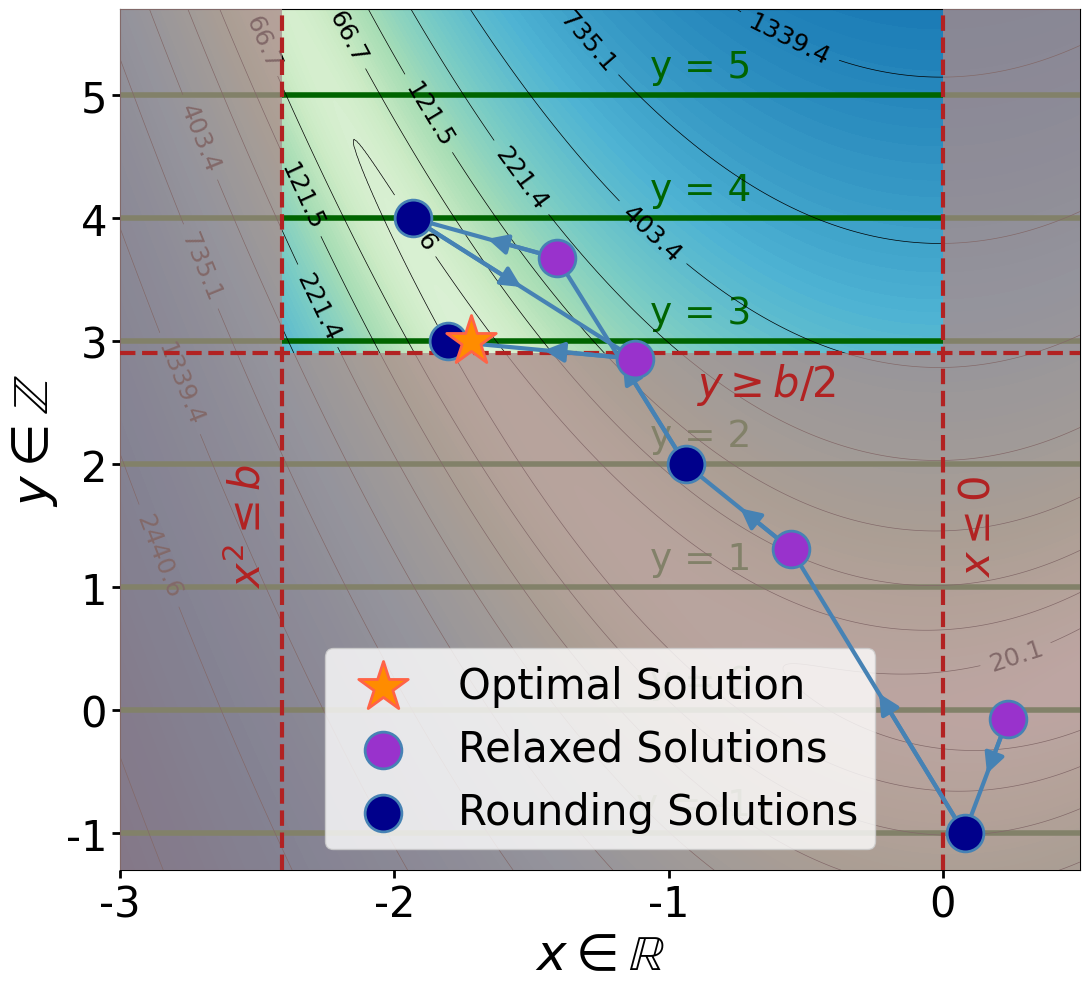

In [80]:
# plot
fig, ax = plt.subplots(figsize=(11, 10))
# contour map
contour_levels = np.linspace(Z_log.min(), Z_log.max(), 100)
contour = ax.contourf(X, Y, Z_log, levels=contour_levels, cmap="GnBu", zorder=0)
# integer y
for y_int in range(-1,6):
    ax.axhline(y=y_int, color="darkgreen", linewidth=4, zorder=1)
    ax.text(-0.7, y_int+0.15, f"y = {y_int}", color="darkgreen", fontsize=27, ha="right", zorder=1)
# add colar bar
#cbar = fig.colorbar(contour, ax=ax)
#log_ticks = np.linspace(Z_log.min(), Z_log.max(), num=10)
#cbar.set_ticks(log_ticks)
#cbar.set_ticklabels([f"{np.exp(tick):.1f}" for tick in log_ticks])
#cbar.set_label("Objective Value")
# add cotour line
contour_lines = ax.contour(X, Y, Z_log, levels=10, colors="black", linewidths=0.5, zorder=2)
ax.clabel(contour_lines, fmt=lambda val: f"{np.exp(val):.1f}", fontsize=18, zorder=2)
# infeasible region
infeasible_region = np.logical_not(constraint_mask)
ax.contourf(X, Y, infeasible_region, levels=[0.5, 1], colors="rosybrown", alpha=0.7, zorder=3)
ax.contourf(X, Y, infeasible_region, levels=[0.5, 1], colors="grey", alpha=0.2, zorder=3)
# constraints
ax.axvline(x=0, color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(0.05, 1.5, "$x \leq 0$", color="firebrick", fontsize=30, ha="left", va="center", rotation=90, zorder=4)
ax.axvline(x=-np.sqrt(p.item()), color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(-np.sqrt(p.item())-0.2, 1.5, "$x^2 \leq b$", color="firebrick", fontsize=30, ha="left", va="center", rotation=90, zorder=4)
ax.axhline(p.item()/2, color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(-0.9, p.item()/2-0.25, "$y \geq b / 2$", color="firebrick", fontsize=30, ha="left", va="center", rotation=0, zorder=4)
# solution
ax.scatter([solvals["x"][0]], [solvals["x"][1]], marker="*", color="darkorange", linewidths=2, 
            edgecolors="tomato", s=1400, label="Optimal Solution", zorder=8)
ax.scatter(rels[:,0], rels[:,1], marker="o", color="darkorchid", 
           edgecolors="steelblue", linewidths=2, s=700, label="Relaxed Solutions", zorder=7)
ax.scatter(rnds[:,0], rnds[:,1], marker="o", color="darkblue", 
           edgecolors="steelblue", linewidths=2, s =700, label="Rounding Solutions", zorder=7)
for i in range(len(sol_seq)-1):
    ax.annotate('', xy=(sol_seq[i+1,0], sol_seq[i+1,1]), xytext=(sol_seq[i,0], sol_seq[i,1]),
                arrowprops=dict(arrowstyle="-", color="steelblue", lw=3, ls="-", mutation_scale=20), zorder=6)
    ax.annotate('', xy=((sol_seq[i+1,0]+sol_seq[i,0])/2, (sol_seq[i+1,1]+sol_seq[i,1])/2), xytext=(sol_seq[i,0], sol_seq[i,1]),
                arrowprops=dict(arrowstyle="-|>", color="steelblue", lw=3, ls="-", mutation_scale=30), zorder=6)
# ticks
ax.tick_params(axis='both', which='major', labelsize=24, length=6, width=2)
ax.set_xticks(range(-3,1))
ax.set_xticklabels(range(-3, 1), fontsize=30)
ax.set_yticks(range(-1,6))
ax.set_yticklabels(range(-1, 6), fontsize=30)
# label
#ax.set_title("Different Epochs of Training for the Same Instance", fontsize=48)
ax.set_xlabel("$x \in \mathbb{R}$", fontsize=36)
ax.set_ylabel("$y \in \mathbb{Z}$", fontsize=36)
ax.legend(fontsize=30)
# show
plt.tight_layout()
plt.savefig("./img/example.pdf", format="pdf", bbox_inches="tight")
plt.show()